<a href="https://colab.research.google.com/github/soham-shee/GRUmodels/blob/main/Dataset1_GRU_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Importing all the required libraries**

In [220]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import zipfile
from statsmodels.tsa.seasonal import seasonal_decompose

In [46]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
replace __MACOSX/._archive? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [350]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Demand')
    plt.plot(predicted, color='green',label='Predicted Demand')
    plt.title('Demand Prediction')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

# Calculation of Root Mean Squared-Error

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [204]:
df1=pd.read_csv('/content/archive/continuous dataset.csv',index_col=[0],parse_dates=[0])
df2=pd.read_excel('/content/archive/test_dataframes.xlsx',index_col=[0],parse_dates=[0])
df3=pd.read_excel('/content/archive/train_dataframes.xlsx',index_col=[0],parse_dates=[0])
df4=pd.read_csv('/content/archive/weekly pre-dispatch forecast.csv',index_col=[0],parse_dates=[0]);

In [205]:
df1

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


We only need the nat_demand column



Now, we will calculate only the weekly data for datetime, and nat_demand

In [386]:
df1_refined=df1['nat_demand'].resample('D').sum()

In [387]:
df1_refined

datetime
2015-01-03    24593.1315
2015-01-04    24194.9663
2015-01-05    27520.3902
2015-01-06    27441.4663
2015-01-07    27458.3716
                 ...    
2020-06-23    27296.7922
2020-06-24    27148.7190
2020-06-25    28416.6890
2020-06-26    26550.6647
2020-06-27     1013.5683
Freq: D, Name: nat_demand, Length: 2003, dtype: float64

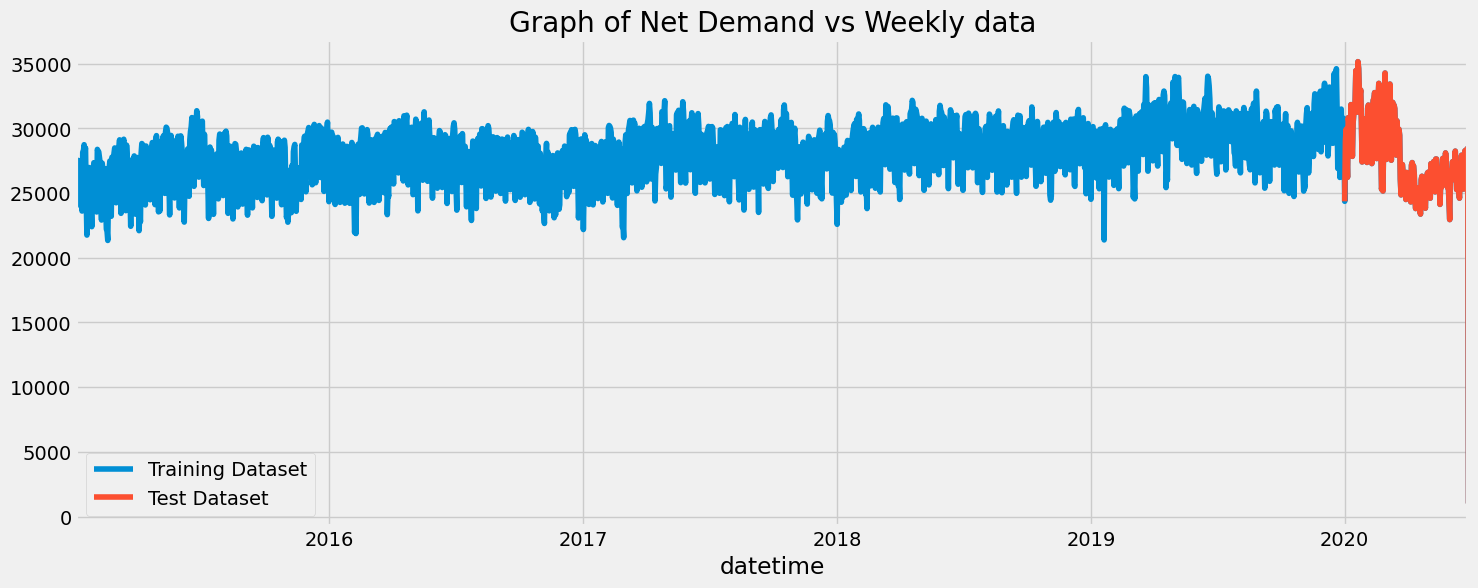

In [453]:
df1_refined[:'2020'].plot(figsize=(16,6),legend=True)
df1_refined['2020':].plot(figsize=(16,6),legend=True)
plt.legend(['Training Dataset','Test Dataset'])
plt.title('Graph of Net Demand vs Weekly data')
plt.show()

Here, we are trying to check the overall trend of the nat_demand

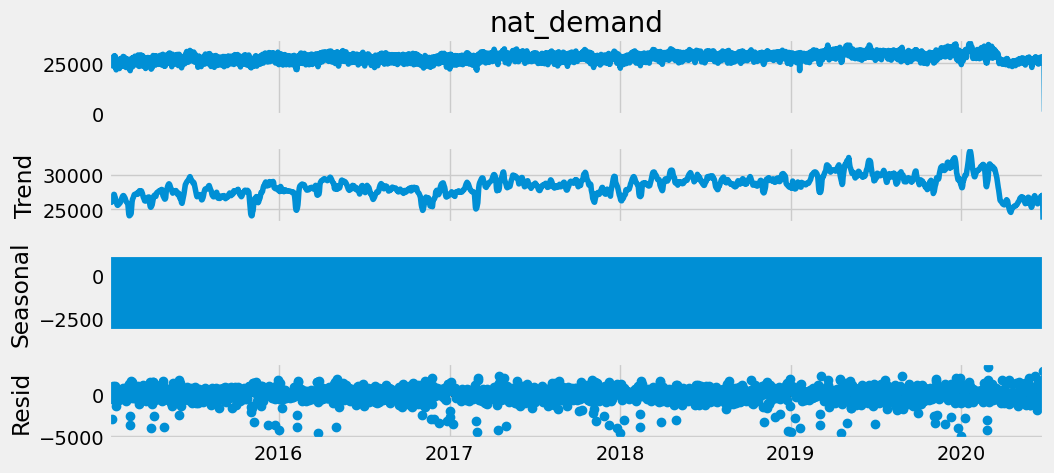

In [472]:
decomp = seasonal_decompose(df1_refined[:])
fig = decomp.plot()
fig.set_figheight(5)
fig.set_figwidth(12)

In [456]:
# Checking for missing values
training_set = df1_refined[:'2020'].values
test_set = df1_refined['2020'].values
training_set=training_set.reshape((training_set.shape[0],1))
test_set=test_set.reshape((test_set.shape[0],1))

In [457]:
print("Training Set Shape : ",training_set.shape)
print("Test Set Shape : ",test_set.shape)

Training Set Shape :  (2003, 1)
Test Set Shape :  (179, 1)


**Scaling the training set from values 0 to 1**

In [458]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [459]:
training_set_scaled.shape

(2003, 1)

In [461]:
X_train = []
Y_train = []
for i in range(100,2003):
    X_train.append(training_set_scaled[i-100:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [462]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

So, now it takes 100 past values, to give out next value.

**Our GRU Model**

In [463]:
EPOCHS=50

model = Sequential()
model.add(GRU(64, activation='tanh',return_sequences=True, input_shape=(100, 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 100, 64)           12864     
                                                                 
 gru_38 (GRU)                (None, 50)                17400     
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30315 (118.42 KB)
Trainable params: 30315 (118.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [464]:
model.fit(X_train,Y_train, epochs=EPOCHS, batch_size=72, shuffle=False)

Epoch 1/50
27/27 [==============================] - 10s 181ms/step - loss: 0.1172
Epoch 2/50
27/27 [==============================] - 3s 120ms/step - loss: 0.0107
Epoch 3/50
27/27 [==============================] - 3s 119ms/step - loss: 0.0091
Epoch 4/50
27/27 [==============================] - 3s 120ms/step - loss: 0.0084
Epoch 5/50
27/27 [==============================] - 5s 173ms/step - loss: 0.0082
Epoch 6/50
27/27 [==============================] - 3s 120ms/step - loss: 0.0077
Epoch 7/50
27/27 [==============================] - 3s 121ms/step - loss: 0.0073
Epoch 8/50
27/27 [==============================] - 4s 137ms/step - loss: 0.0073
Epoch 9/50
27/27 [==============================] - 4s 150ms/step - loss: 0.0074
Epoch 10/50
27/27 [==============================] - 3s 120ms/step - loss: 0.0067
Epoch 11/50
27/27 [==============================] - 3s 119ms/step - loss: 0.0073
Epoch 12/50
27/27 [==============================] - 4s 159ms/step - loss: 0.0069
Epoch 13/50
27/27 [=====

In [465]:
dataset_total = pd.concat((df1_refined[:'2020'],df1_refined['2020':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 100:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

**Predicting the** *nat_demand*  **for 2020 and beyond**

In [466]:
X_test = []
for i in range(100,279):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_data = model.predict(X_test)
predicted_data = sc.inverse_transform(predicted_data)

6/6 [==============================] - 1s 41ms/step


**Actual Demand vs Predicted Demand**

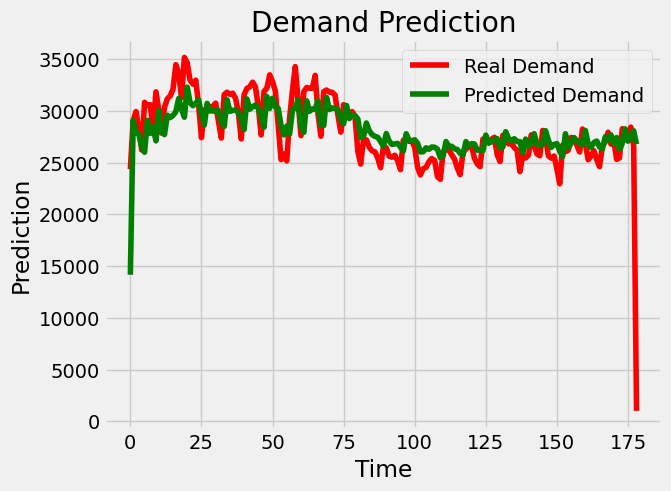

In [467]:
plot_predictions(test_set,predicted_data)

In [468]:
return_rmse(test_set,predicted_data)

The root mean squared error is 2709.2117368013314.
